In [2]:
import os,sys
import matplotlib.pyplot as plt 
import numpy as np
import torch.utils.data as data_utils
import torchvision
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import ndarray

In [9]:
device = 'cuda'

In [4]:
#önişlemede kaydedilen tensörleri indirme
os.chdir(r"C:\Users\emirh\Desktop\ai_hub_proje\tensors")
X_train_t = torch.load('X_train_t.pt')
X_test_t = torch.load('X_test_t.pt')
X_val_t = torch.load('X_val_t.pt')
y_train_t = torch.load('y_train_t.pt')
y_test_t = torch.load('y_test_t.pt')
y_val_t = torch.load('y_val_t.pt')

In [5]:
X_train_t.shape, X_test_t.shape, X_val_t.shape

(torch.Size([6112, 1, 128, 128]),
 torch.Size([1310, 1, 128, 128]),
 torch.Size([1310, 1, 128, 128]))

In [6]:
y_train_t.shape, y_test_t.shape, y_val_t.shape

(torch.Size([6112]), torch.Size([1310]), torch.Size([1310]))

In [53]:
train = data_utils.TensorDataset(X_train_t, y_train_t)
train_loader = data_utils.DataLoader(train, batch_size=128, shuffle=True)
test = data_utils.TensorDataset(X_test_t, y_test_t)
test_loader = data_utils.DataLoader(test, batch_size=128, shuffle=True)
val = data_utils.TensorDataset(X_val_t, y_val_t)
val_loader = data_utils.DataLoader(val, batch_size=128, shuffle=True)

In [54]:
#CNN modelini tanımlama
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=128*9*9, out_features=10)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x
net = Net()
net = net.to(device)

In [55]:
#Loss function ve optimizer tanımla
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [56]:
epochs = 200
min_valid_loss = np.inf
train_loss_list = []
val_loss_list = []

for e in range(epochs):
    train_loss = 0.0
    net.train()     # Optional when not using Model Specific layer
    for data, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = net(data)
        loss = criterion(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss/len(train_loader))
    
    valid_loss = 0.0
    net.eval()     # Optional when not using Model Specific layer
    for data, labels in val_loader:
        labels = labels.type(torch.LongTensor)
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = net(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)
    val_loss_list.append(valid_loss/len(val_loader))
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # net'i kaydet
        torch.save(net.state_dict(), 'saved_model.pth')

Epoch 1 		 Training Loss: 2.1180793220798173 		 Validation Loss: 5.32173059203408
Validation Loss Decreased(inf--->58.539037) 	 Saving The Model
Epoch 2 		 Training Loss: 2.0253326346476874 		 Validation Loss: 5.871380242434415
Epoch 3 		 Training Loss: 1.9979338000218074 		 Validation Loss: 5.5802223899147725
Epoch 4 		 Training Loss: 1.963235671321551 		 Validation Loss: 5.315732522444292
Validation Loss Decreased(58.539037--->58.473058) 	 Saving The Model
Epoch 5 		 Training Loss: 1.940329981346925 		 Validation Loss: 5.2422614531083545
Validation Loss Decreased(58.473058--->57.664876) 	 Saving The Model
Epoch 6 		 Training Loss: 1.9235815902551014 		 Validation Loss: 5.440058599818837
Epoch 7 		 Training Loss: 1.9072921176751454 		 Validation Loss: 5.4482456770810215
Epoch 8 		 Training Loss: 1.904681958258152 		 Validation Loss: 4.956360080025413
Validation Loss Decreased(57.664876--->54.519961) 	 Saving The Model
Epoch 9 		 Training Loss: 1.8854498689373334 		 Validation Loss: 5.

In [57]:
#modelin test edilmesi için sample aldık
classes = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]
dataiter = iter(test_loader)
images, labels = dataiter.next()
print('GroundTruth: ', ' // '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

GroundTruth:  air_conditioner // engine_idling // siren // engine_idling // gun_shot // air_conditioner // air_conditioner // dog_bark // jackhammer // drilling


In [58]:
PATH = r"C:\Users\emirh\Desktop\ai_hub_proje\tensors\saved_model.pth"
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [59]:
outputs = net(images)

In [60]:
#modeli test ediyoruz
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' // '.join(f'{classes[predicted[j]]:5s}' for j in range(10)))

Predicted:  air_conditioner // engine_idling // siren // engine_idling // gun_shot // air_conditioner // jackhammer // dog_bark // jackhammer // drilling


In [61]:
# her sınıf için accuracy hesaplama
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: air_conditioner is 84.5 %
Accuracy for class: car_horn is 0.0 %
Accuracy for class: children_playing is 69.1 %
Accuracy for class: dog_bark is 83.1 %
Accuracy for class: drilling is 85.9 %
Accuracy for class: engine_idling is 94.4 %
Accuracy for class: gun_shot is 94.8 %
Accuracy for class: jackhammer is 90.9 %
Accuracy for class: siren is 89.4 %
Accuracy for class: street_music is 90.6 %


In [62]:
print(len(train_loss_list), len(val_loss_list))

200 200


<function matplotlib.pyplot.show(close=None, block=None)>

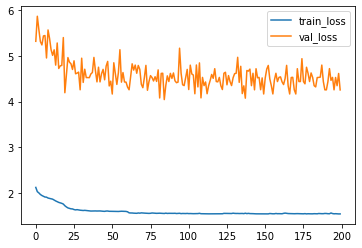

In [65]:
#train ve validation loss grafikleri
x = list(range(0,200))
plt.plot(x, train_loss_list, label="train_loss")
plt.plot(x, val_loss_list, label="val_loss")
plt.legend()
plt.show
